Geek for geeks website information regardding strip plots.

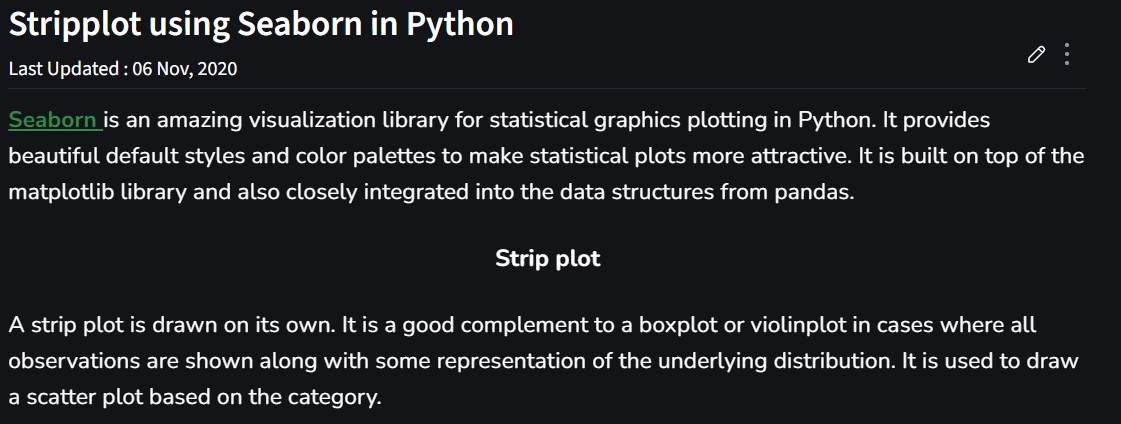

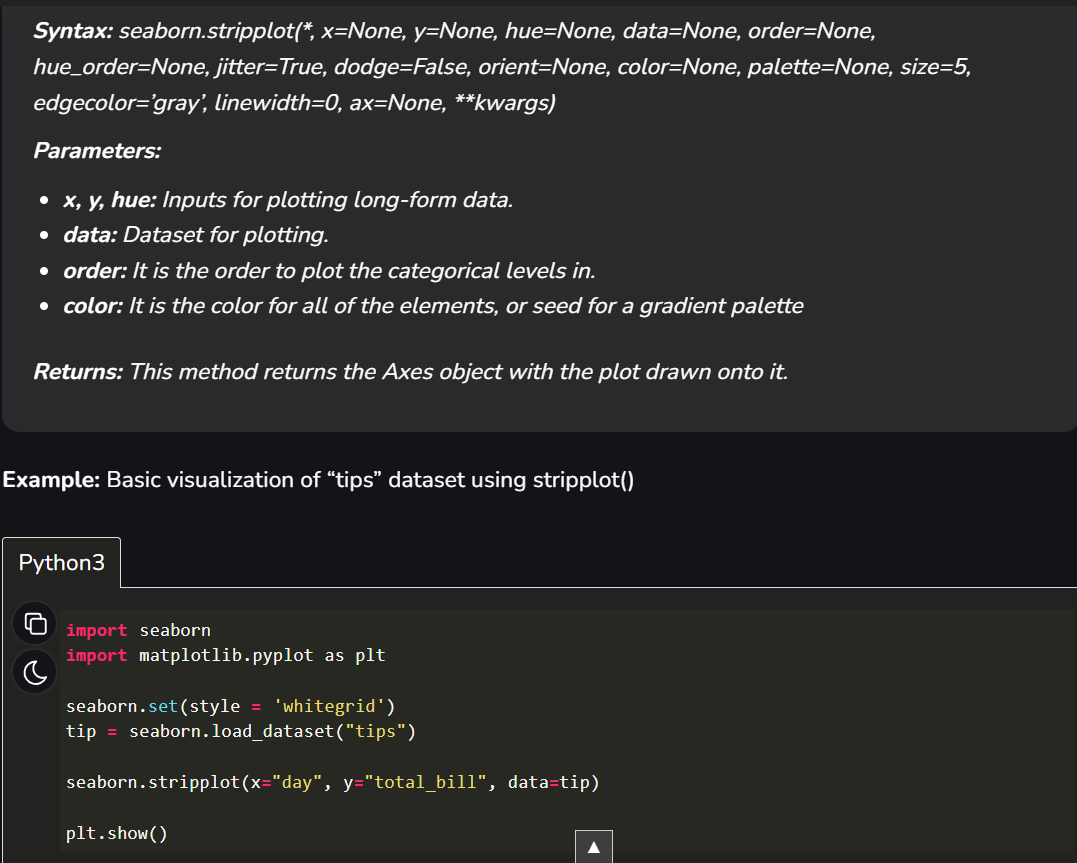

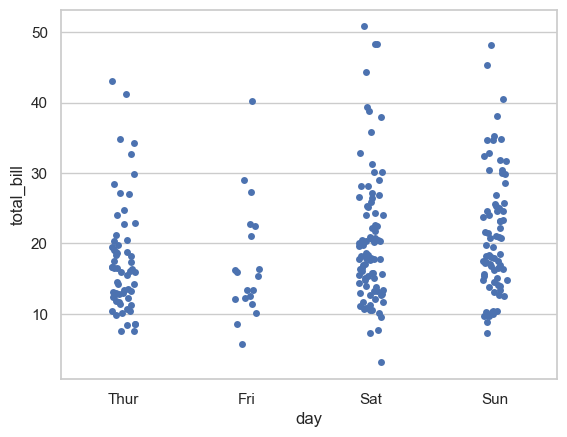

In [1]:
import seaborn 
import matplotlib.pyplot as plt 
       
seaborn.set(style = 'whitegrid')   
tip = seaborn.load_dataset("tips")   
       
seaborn.stripplot(x="day", y="total_bill", data=tip) 
  
plt.show()

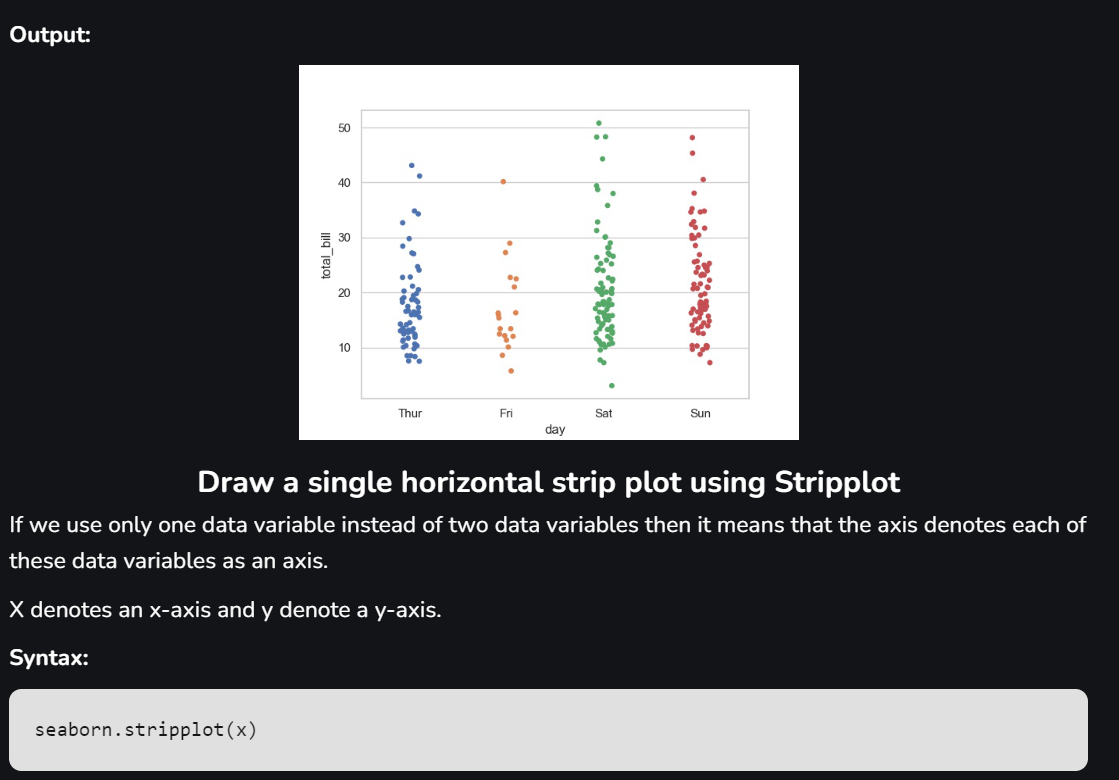

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Sample data
data = {
    'url': [
        'sberauto.com/cars/all/renault/logan/8c3c73f2?utm_source_initial=google&utm_medium_initial=cpc&utm_campaign_initial=XHNUiSKKGTEpSAlaVMFQ',
        'sberauto.com/cars/all/skoda/rapid/bf24b977?rental_page=rental_car',
        'sberauto.com/cars?utm_source_initial=yandex&utm_medium_initial=cpc&utm_campaign_initial=SzZERoLMmrEUEhDaYcyN',
        # Add more URLs here...
    ]
}

df = pd.DataFrame(data)

# Vectorize the URLs
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['url'])

# Apply KMeans clustering
n_clusters = 5  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Inspect the cluster assignments
print(df)

# Example of manual labeling based on clusters
cluster_labels = {
    0: 'Renault Logan Page',
    1: 'Skoda Rapid Page',
    2: 'Yandex CPC Campaign Page',
    # Add labels for other clusters...
}

df['label'] = df['cluster'].map(cluster_labels)

# Drop the cluster column if no longer needed
df.drop('cluster', axis=1, inplace=True)

# Display the DataFrame with labels
print(df)



In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from urllib.parse import urlparse, parse_qs

# Sample data
data = {
    'url': [
        'sberauto.com/cars/all/renault/logan/8c3c73f2?utm_source_initial=google&utm_medium_initial=cpc&utm_campaign_initial=XHNUiSKKGTEpSAlaVMFQ',
        'sberauto.com/cars/all/skoda/rapid/bf24b977?rental_page=rental_car',
        'sberauto.com/cars?utm_source_initial=yandex&utm_medium_initial=cpc&utm_campaign_initial=SzZERoLMmrEUEhDaYcyN',
        # Add more URLs here...
    ]
}

df = pd.DataFrame(data)

# Step 1: Calculate Pairwise Similarities
def calculate_similarity_matrix(urls):
    n = len(urls)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            similarity = fuzz.ratio(urls[i], urls[j])
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity
    return similarity_matrix

urls = df['url'].tolist()
similarity_matrix = calculate_similarity_matrix(urls)

# Step 2: Apply Clustering
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=70)
df['cluster'] = clustering.fit_predict(100 - similarity_matrix)  # 100 - similarity to convert similarity to distance

# Step 3: Extract Key Features
def extract_features(url):
    parsed_url = urlparse(url)
    path = parsed_url.path
    query = parse_qs(parsed_url.query)
    return path, query

df['features'] = df['url'].apply(extract_features)

# Step 4: Automatically Label Clusters
def label_cluster(cluster_df):
    common_paths = cluster_df['features'].apply(lambda x: x[0]).mode().tolist()
    common_queries = cluster_df['features'].apply(lambda x: x[1]).mode().tolist()

    # Create a label based on common path segments
    label = "Cluster"
    if common_paths:
        label += f" Path: {common_paths[0]}"
    if common_queries:
        label += f" Query: {list(common_queries[0].keys())[:2]}"  # Limit to first 2 query params for simplicity

    return label

cluster_labels = {}
for cluster_id in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster_id]
    cluster_labels[cluster_id] = label_cluster(cluster_df)

df['label'] = df['cluster'].map(cluster_labels)

# Drop the features and cluster columns if no longer needed
df.drop(['features', 'cluster'], axis=1, inplace=True)

# Display the DataFrame with labels
print(df)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sample data
data = {
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'feature2': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    'target': [0, 0, 0, 1, 1, 1, 1, 0, 0, 1]
}

df = pd.DataFrame(data)

# Split the data into training and testing sets
X = df[['feature1', 'feature2']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get the predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display new class counts
print(pd.Series(y_resampled).value_counts())


In [ ]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()